# Polydisperse systems,

In many cases, it can be useful to have traps or particles with different properties. This is supported both by `icenumerics`. 

In [1]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../../../')

import icenumerics as ice

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as spa


import warnings
warnings.filterwarnings("error")

%load_ext autoreload
%autoreload 2

### We first create a colloidal ice to play around with

In [2]:
ureg = ice.ureg

In [3]:
sp = ice.spins()
sp.create_lattice("square",[10,10],lattice_constant=30*ureg.um, border="closed spin")

In [4]:
particle = ice.particle(radius = 5.15*ureg.um,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap1 = ice.trap(trap_sep = 10*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

trap2 = ice.trap(trap_sep = 5*ureg.um,
               height = 80*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

traps = [trap1 if (s.direction[1]==0) else trap2 for s in sp]

col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)
col.pad_region(30*ureg.um)

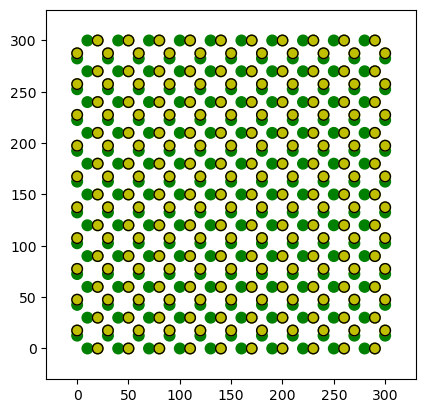

In [5]:
col.display()

In [6]:
world = ice.world(
    field = 20*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

col.simulate(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = 10*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = 10*ureg.s,
             output = ["x","y","z","mux","muy","muz"])

scanning file


  0%|          | 0/1403985 [00:00<?, ?it/s]

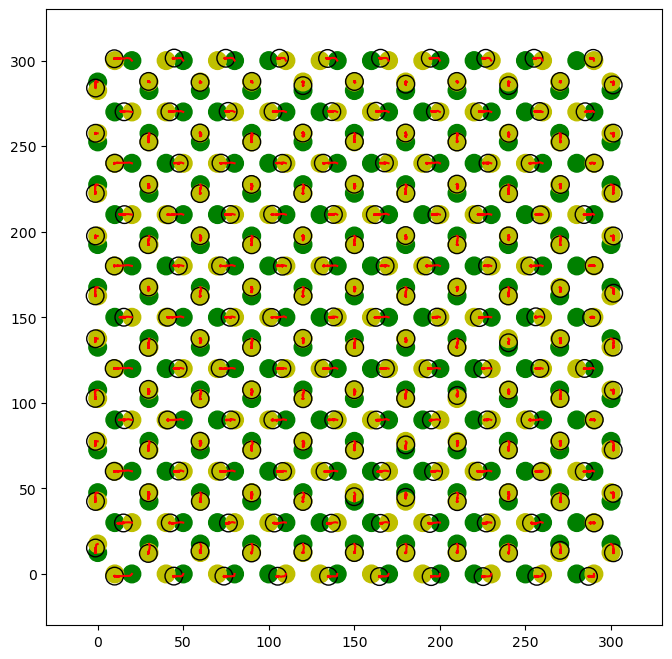

In [7]:
f, (ax2) = plt.subplots(1,1,figsize = (8,8))
col.display(ax2)
for i, trj_i in col.trj.groupby("id"):
    if all(trj_i.type==1):
        plt.plot(trj_i.x,trj_i.y, color = "r")

## Create a 'vertex' object from a 'colloidal_ice' object

In [8]:
v = ice.vertices()
v.colloids_to_vertices(col)

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

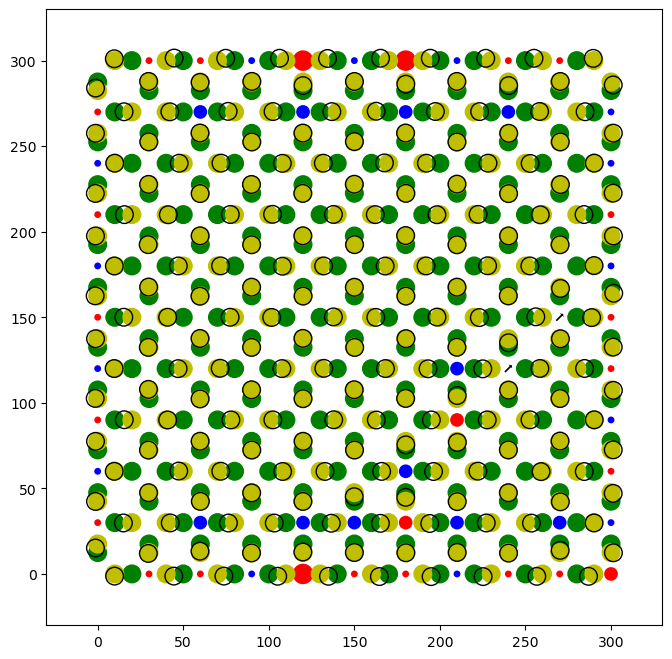

In [9]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

## Create a vertex structure from the results of lammps.

We can get the vertex structure from a trajectory. To do this, the trajectory must be in the 'ice' format obtained by 'get_ice_trj':

In [10]:
trj = col.trj.copy(deep=True)
trj.head()

type      x    y    z  mux  muy       muz    t
frame id                                                
0     1      1   20.0  0.0  0.0  0.0  0.0  0.001754  0.0
      2      1   50.0  0.0  0.0  0.0  0.0  0.001754  0.0
      3      1   80.0  0.0  0.0  0.0  0.0  0.001754  0.0
      4      1  110.0  0.0  0.0  0.0  0.0  0.001754  0.0
      5      1  140.0  0.0  0.0  0.0  0.0  0.001754  0.0

In [11]:
col_trj = ice.get_ice_trj(trj, col.bnd, atom_types = 1, trap_types = [2,3])

In [12]:
col_trj.head()

type      x     y    z   dx   dy   dz    t            cx   cy   cz
frame id                                                                    
0     0      2    0.0  15.0  0.0  0.0  5.0  0.0  0.0  0.000000e+00  2.5  0.0
      1      2   30.0  15.0  0.0  0.0  5.0  0.0  0.0  0.000000e+00  2.5  0.0
      2      2   60.0  15.0  0.0  0.0  5.0  0.0  0.0 -1.421085e-14  2.5  0.0
      3      2   90.0  15.0  0.0  0.0  5.0  0.0  0.0  0.000000e+00  2.5  0.0
      4      2  120.0  15.0  0.0  0.0  5.0  0.0  0.0  0.000000e+00  2.5  0.0

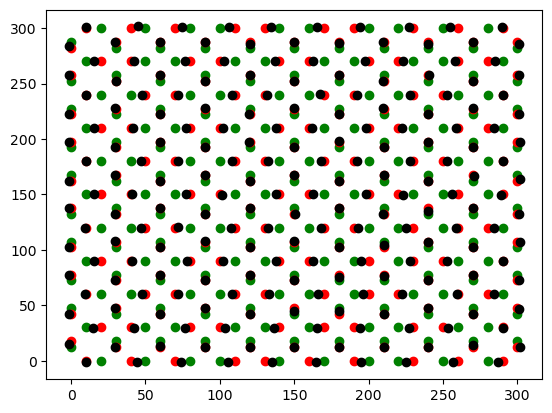

In [13]:
i = 99

plt.plot(
        col_trj.loc[i].x-col_trj.loc[i].dx/2,
        col_trj.loc[i].y-col_trj.loc[i].dy/2,
        'o', color = "green")

plt.plot(
        col_trj.loc[i].x+col_trj.loc[i].dx/2,
        col_trj.loc[i].y+col_trj.loc[i].dy/2,
        'o', color = "red")

plt.plot(
        col_trj.loc[i].x+col_trj.loc[i].cx,
        col_trj.loc[i].y+col_trj.loc[i].cy,
        'o', color = "k")

In [14]:
v = ice.vertices()
frame = 99
v = v.trj_to_vertices(col_trj.loc[frame])

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

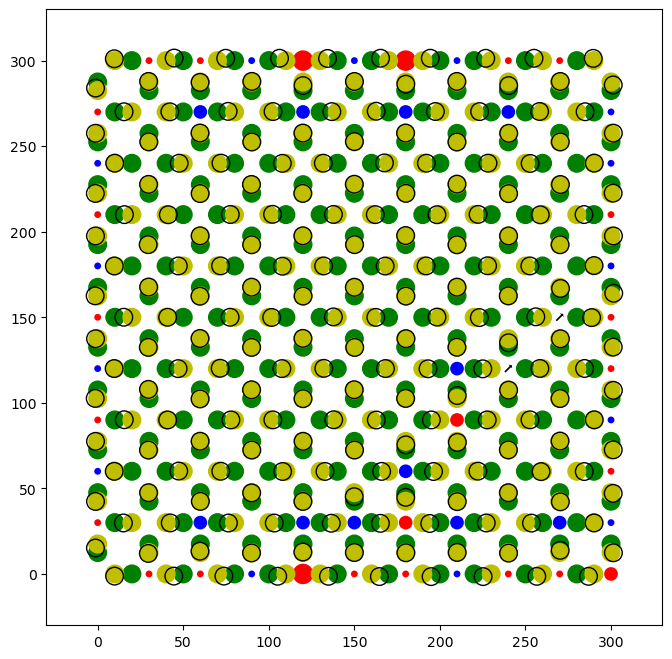

In [15]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)

### Multiple frames

If the 'trj' is a MultiIndex, the 'trj_to_vertices' method will iterate over all the indices which are not 'id', and calculate the vertex structure of all frames. However, it will only calculate the topology of the first frame. 

In [17]:
%%time
v = ice.vertices()
frames = col_trj.index.get_level_values("frame").unique()

v.trj_to_vertices(col_trj.loc[frames[:]])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

CPU times: user 33 s, sys: 1.24 s, total: 34.2 s
Wall time: 33.9 s


In [18]:
v.vertices.head()

x      y  coordination  charge   dx   dy
frame vertex                                              
0     0       300.0  150.0             3       1  1.0  2.0
      1       150.0  300.0             3       1  2.0  1.0
      2        60.0  300.0             3       1  2.0  1.0
      3        30.0  300.0             3       1  2.0  1.0
      4       300.0  180.0             3       1  1.0  2.0

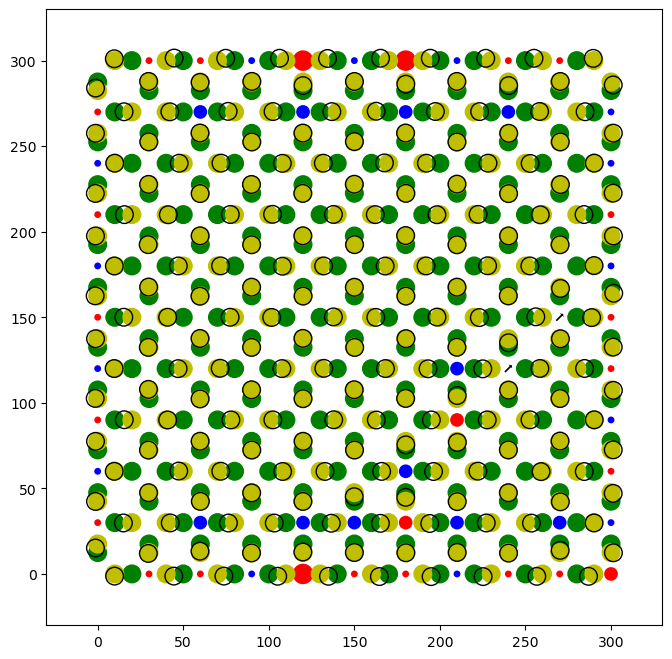

In [19]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))

v.display(ax1)
col.display(ax1)